**LSTM** (Long Short Term Memory) is a type of **RNN** (Recurrent Neural Network) for learning sequence data (such **time series**) where the data has **dependency** on previous observations.

This example use past few days close price of Bitcoin to predict next day close price (**one-step forecast**).


*   Past few days closing price -> Next day closing price


It's an **univariate** (i.e. a single feature of close price) example. For more details: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

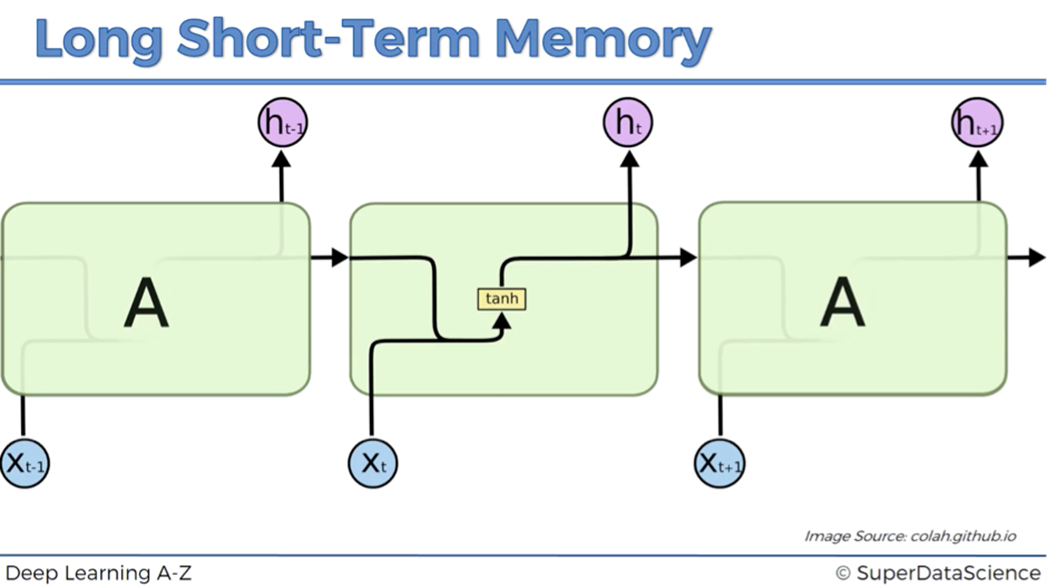


In [1]:
#@title Execute this block to import TensorFlow deep learning library and helper functions

import datetime
import statistics as stats
from numpy import array
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels
import warnings

# Ignore warnings from statsmodels
warnings.filterwarnings("ignore")

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

RUN_AR_MODEL=True
IS_INTERACTIVE=False

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


def getPrediction(lstm, raw_seq, index, n_steps, n_features):
  x_seq = raw_seq[index-n_steps : index]
  x_seq = x_seq.reshape(1, n_steps, n_features)

  #print("TYPE x_seq:" + str(type(x_seq)))
  #print(x_seq)

  yhat = lstm.predict(x_seq,verbose=None)
  y = raw_seq[index]

  return x_seq, yhat, y


# predict the next day close as the same as today's close
def getBasePrediction(raw_seq, index, n_steps):
  x_seq = raw_seq[index-n_steps : index]

  yhat = x_seq[len(x_seq)-1]
  y = raw_seq[index]

  return x_seq, yhat, y


def roundNum(num, dp=2):
	return round(num, dp)

In [2]:
#@title Download historical daily data from Yahoo Finance

ticker = 'BTC-USD' # @param ["BTC-USD", "ETH-USD", "NVDA", "0700.HK", "2628.HK", "0941.HK", "0939.HK"] {allow-input: true}
startDate = '2020-01-01' #@param {type:"date"}

stock = yf.Ticker(ticker)

short_name=stock.info['shortName']
#print(stock.info['shortName'])

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
df= stock.history(start=startDate)
#df.index = pd.to_datetime(df.index)
#df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S',exact=False).date
df.index = pd.to_datetime(df.index).date
df.index.name = 'Date'

''' In case Yahoo finance doesn't work, download from github
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/bitcoinHistorical-short.csv'
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
'''

df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,0.0,0.0
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465,0.0,0.0
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,0.0,0.0
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,0.0,0.0
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,0.0,0.0
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,23276261598,0.0,0.0
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,28767291327,0.0,0.0
2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,31672559265,0.0,0.0
2020-01-09,8082.295898,8082.295898,7842.403809,7879.071289,24045990466,0.0,0.0


<Axes: xlabel='Date'>

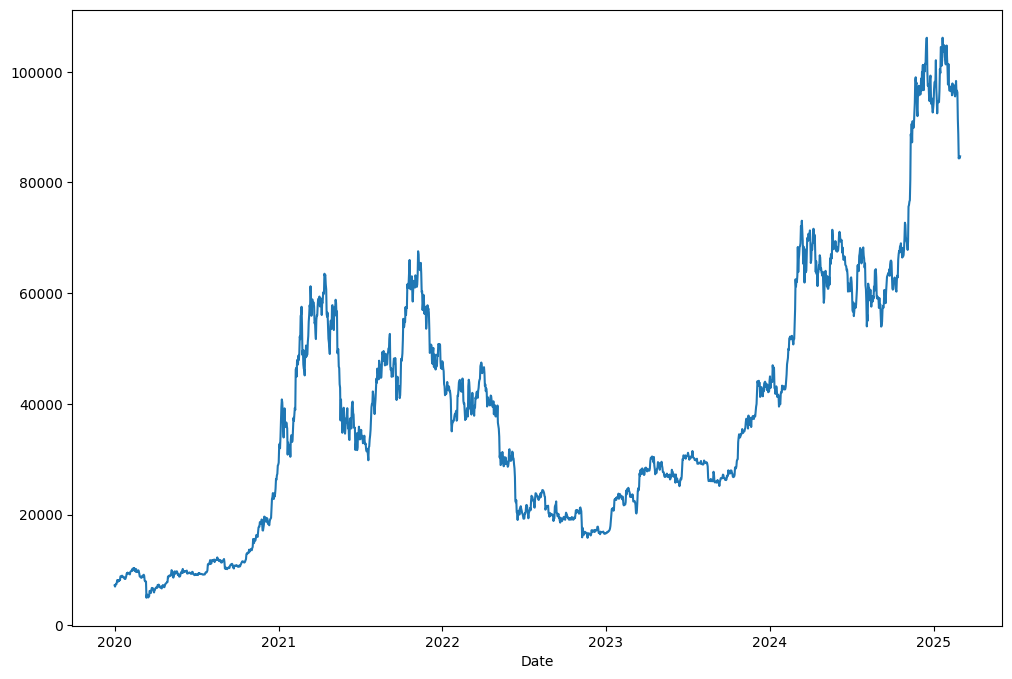

In [3]:
#@title Plot the bitcoin closing price
df['Close'].plot(figsize = (SCREEN_X, SCREEN_Y))

# Prepare the dataset (using closing price feature only)

Split the data into training and test set

* If the samples in the dataset are **independent** of each other (e.g. faces and people names), training and test set can be **randomly split**.

* For time series data, usually **split according to the time period** where the **earlier period is the training set**.


In [4]:
#@title Choose the training dataset ratio

train_ratio = 0.8 #@param {type:"slider", min:0.5, max:0.9, step:0.05}


def divide_dataset(train_ratio):
    # define input sequence and no. of features
    # Use only the "close" price as the input feature
    raw_seq = df['Close'].values
    n_features = raw_seq.ndim
    data_size = len(raw_seq)

    print("data_size:", data_size)

    train_size = round(train_ratio * data_size)
    train_seq = raw_seq[:train_size]
    test_seq = raw_seq[train_size:]

    print("train_size:", train_size)
    print("test_size:", data_size-train_size)
    test_size = data_size - train_size

    df_close_train=pd.DataFrame(columns=['Close'])
    df_close_train['Close']=df['Close'].head(train_size)
    #df_close_train['Date'] = df_close_train['Date'].dt.date
    #df_close_train.set_index('Date',inplace=True)
    df_close_test=pd.DataFrame(columns=['Close'])
    df_close_test['Close']=df['Close'].tail(data_size - train_size)
    #df_close_test['Date'] = df_close_test['Date'].dt.date
    #df_close_test.set_index('Date', inplace=True)

    return raw_seq,train_seq,test_seq,data_size,train_size,test_size,n_features,df_close_train,df_close_test

In [5]:
# Execute the divide dataset function to split the train and test datasets
if IS_INTERACTIVE:
   raw_seq,train_seq,test_seq,data_size,train_size,test_size,n_features,df_close_train,df_close_test = divide_dataset(train_ratio)

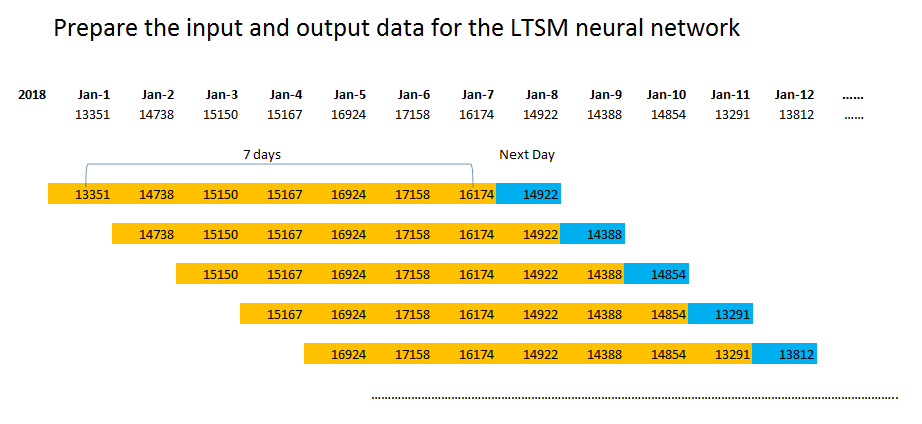

In [6]:
#@title Choose a number of time steps (how many previous closing price to predict the next day closing price)

n_steps = 7 #@param {type:"integer"}

def split_train_data(n_steps, n_features):
    # split into training samples
    x_train, y_train = split_sequence(train_seq, n_steps)

    # reshape from [samples, timesteps] to [samples, timesteps, features]
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)

    print("training data input:", x_train.shape)
    print("training data output:", y_train.shape)

    return x_train, y_train


In [7]:
# Split the training dataset
if IS_INTERACTIVE:
   x_train, y_train = split_train_data(n_steps, n_features)

In [8]:
#@title Show one sample of the input and output from the training data

training_sampe = 0 #@param {type:"integer"}

if IS_INTERACTIVE:
    print(x_train[training_sampe])
    print('--->', y_train[training_sampe])

In [9]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep
def construct_model(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.summary()
    # The lstm (LSTM) Param # = g * [h(h+i) + h]
    # where g is number of gates and LSTM = 4
    # h = no. of LSTM hidden neurons
    # i = the dimension of input (feature)
    # 4 * (32 (32 + 1) + 32) = 4352

    plot_model(model, show_shapes=True, show_layer_names=True)

    return model

In [10]:
# Construct the LSTM model
if IS_INTERACTIVE:
   model = construct_model(n_steps, n_features)

In [11]:
#@title Train the LSTM Neural Network with the input number of epochs

epochs = 20 #@param {type:"integer"}

def LSTM_train_model(model, epochs):
    # fit model
    history = model.fit(x_train, y_train, epochs=epochs)

    # Plot the loss
    loss = history.history['loss']
    epoch = range(1, len(loss) + 1)

    plt.plot(epoch, loss, 'r', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

    return model



In [12]:
# Run the train model
if IS_INTERACTIVE:
   model = LSTM_train_model(model, epochs)

In [13]:
#@title Pick one sample from the testing data to verify the prediction

test_day = 0 #@param {type:"integer"}

def test_verify_prediction(model, n_steps, n_features, test_day):
    # predict the next day
    index = test_day + train_size
    x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)

    predicted = yhat[0][0]
    actual = y
    error = actual - predicted
    errorP = abs(error) / predicted

    print(x_seq, "\n")
    print("Predicted:", predicted)
    print("Actual:", actual)
    print("Error:", error)
    print("Error%:", roundNum(errorP, 4)*100)

In [14]:
# Test and verify prediction from a sample
if IS_INTERACTIVE:
   test_verify_prediction(model, n_steps, n_features, test_day)

In [15]:
#@title Plot the LSTM predicted values (in testing data) vs the actual values

def plot_LSTM_prediction(model, data_size, train_size, n_steps, n_features):
    predictedList = []
    actualList = []

    for i in range(train_size, data_size):
        x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
        predictedList.append(yhat[0][0])
        actualList.append(y)

    # plot the result
    plt.figure(figsize=(SCREEN_X, SCREEN_Y))
    plt.plot(predictedList, label="Predicted(LSTM)")
    plt.plot(actualList, label="Actual")
    plt.legend()

    return predictedList, actualList

    # Each prediction is based on the "actual" observation from the past days
    # Another way is to use multi-step ahead output or use the predicted values as new observations to further predict the rest of the series


In [16]:
# Plot the predicted values along side actual values
if IS_INTERACTIVE:
   predictedList, actualList = plot_LSTM_prediction(model, data_size, train_size, n_steps, n_features)

In [17]:
#@title Print the testing and actual values comparisons
def print_predicted_and_actuals(predictedList, actualList):
    lstmError = []
    lstmErrorP = []
    for i in range(len(predictedList)):
        error = actualList[i]-predictedList[i]
        absError = abs(error)
        errorP = absError/actualList[i]
        lstmError.append(absError)
        lstmErrorP.append(errorP)

        print(str(i+1)+" Predicted:", roundNum(predictedList[i]),
            "  Actual:", roundNum(actualList[i]),
            "  Error:", roundNum(error),
            "->", roundNum(errorP), sep='')

    rmse_lstm = statsmodels.tools.eval_measures.rmse(predictedList, actualList, axis=0)
    print("------------------------------------------------------------------")
    print("Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
    print("Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')
    print("LSTM RMSE: ", rmse_lstm)

    return lstmError, lstmErrorP, rmse_lstm


In [18]:
# Print the LSTM predicted and actual values

if IS_INTERACTIVE:
   lstmError, lstmErrorP, rmse_lstm = print_predicted_and_actuals(predictedList, actualList)

In [19]:
#@title Baseline comparison: predict the next day closing price as the same as today's closing price

def compare_prediction_using_baseline(data_size, train_size, n_steps):
     basePredictedList = []
     baseActualList = []

     for i in range(train_size, data_size):
         x_seq, yhat, y = getBasePrediction(raw_seq, i, n_steps)
         basePredictedList.append(yhat)
         baseActualList.append(y)


     # look at the individual predictions
     baseError = []
     baseErrorP = []
     for i in range(len(basePredictedList)):
         error = baseActualList[i]-basePredictedList[i]
         absError = abs(error)
         errorP = absError/baseActualList[i]
         baseError.append(absError)
         baseErrorP.append(errorP)

         print(str(i+1) + " Predicted:", roundNum(basePredictedList[i]),
              "  Actual:", roundNum(baseActualList[i]),
              "  Error:", roundNum(error),
              "->", roundNum(errorP), sep='')

     rmse_baseline = statsmodels.tools.eval_measures.rmse(basePredictedList, baseActualList, axis=0)
     print("------------------------------------------------------------------")
     print("Baseline Error: Total=",roundNum(sum(baseError)), " Average=",roundNum(stats.mean(baseError)), " Min=",roundNum(min(baseError)), " Max=",roundNum(max(baseError)), sep='')
     print("Baseline Error Ratio: Average=",roundNum(stats.mean(baseErrorP)), " Min=",roundNum(min(baseErrorP)), " Max=",roundNum(max(baseErrorP)), sep='')
     print("Baseline RMSE: ", rmse_baseline )


     print("------------------------------------------------------------------")
     print("LSTM Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
     print("LSTM Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')
     print("LSTM RMSE: ", rmse_lstm)

     return basePredictedList, baseActualList, rmse_baseline

In [20]:
# Using baseline prediction for comparison with LSTM
if IS_INTERACTIVE:
   basePredictedList, baseActualList, rmse_baseline = compare_prediction_using_baseline(data_size, train_size, n_steps)

In [21]:
#@title Plot the predicted values (in testing data) vs the actual values

def plot_baseline_prediction(basePredictedList, baseActualList):
    plt.figure(figsize=(SCREEN_X, SCREEN_Y))
    plt.plot(basePredictedList, label="Predicted(Baseline)")
    plt.plot(baseActualList, label="Actual")
    plt.legend()

In [22]:
# Plot baseline predicted Vs Actuals

if IS_INTERACTIVE:
   plot_baseline_prediction(basePredictedList, baseActualList)

In [23]:
#@title Plot all results

def plot_prediction_all(predictedList, basePredictedList, baseActualList):
    plt.figure(figsize=(SCREEN_X, SCREEN_Y))
    plt.plot(predictedList, label="LSTM")
    plt.plot(basePredictedList, label="Base")
    plt.plot(baseActualList, label="Actual")
    plt.legend()

In [24]:
# Plot all results

if IS_INTERACTIVE:
   plot_prediction_all(predictedList, basePredictedList, baseActualList)


In [25]:
#print("df_close_train SIZE: " + str(df_close_train.size))
#print(df_close_train.tail(5))

#print("df_close_test SIZE: " + str(df_close_test.size))
#print(df_close_test.head(5))



*******Start*******: Train Ratio:  0.5  n_steps:  7  Epochs:  10
data_size: 1887
train_size: 944
test_size: 943
training data input: (937, 7, 1)
training data output: (937,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1130738048.0000
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1080476928.0000
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1042659264.0000
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 748419520.0000
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 344947008.0000
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16142487.0000
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7133708.5000
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 203868032.0000
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 637093248.0000
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 263304576.0000


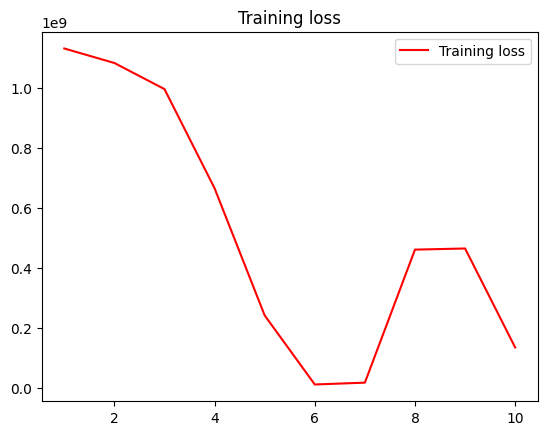

[[[21239.75390625]
  [22930.54882812]
  [23843.88671875]
  [23804.6328125 ]
  [23656.20703125]
  [23336.89648438]
  [23314.19921875]]] 

Predicted: 19229.176
Actual: 22978.1171875
Error: 3748.94140625
Error%: 19.5
1 Predicted:19229.18  Actual:22978.12  Error:3748.94->0.16
2 Predicted:19660.11  Actual:22846.51  Error:3186.4->0.14
3 Predicted:19764.7  Actual:22630.96  Error:2866.26->0.13
4 Predicted:19632.25  Actual:23289.31  Error:3657.06->0.16
5 Predicted:19546.08  Actual:22961.28  Error:3415.2->0.15
6 Predicted:19373.0  Actual:23175.89  Error:3802.89->0.16
7 Predicted:19333.99  Actual:23809.49  Error:4475.5->0.19
8 Predicted:19323.48  Actual:23164.32  Error:3840.84->0.17
9 Predicted:19282.46  Actual:23947.64  Error:4665.19->0.19
10 Predicted:19445.1  Actual:23957.53  Error:4512.42->0.19
11 Predicted:19592.96  Actual:24402.82  Error:4809.86->0.2
12 Predicted:19679.75  Actual:24424.07  Error:4744.32->0.19
13 Predicted:19847.57  Actual:24319.33  Error:4471.77->0.18
14 Predicted:20010.16 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2750822144.0000
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 600971456.0000
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14286954.0000
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29637350.0000
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9893681.0000 
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11278056.0000
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7686249.5000
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16141935.0000
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9972228.0000 
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8066366.0000
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7090412.5000
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5869098.0000
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8292755.0000
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 884

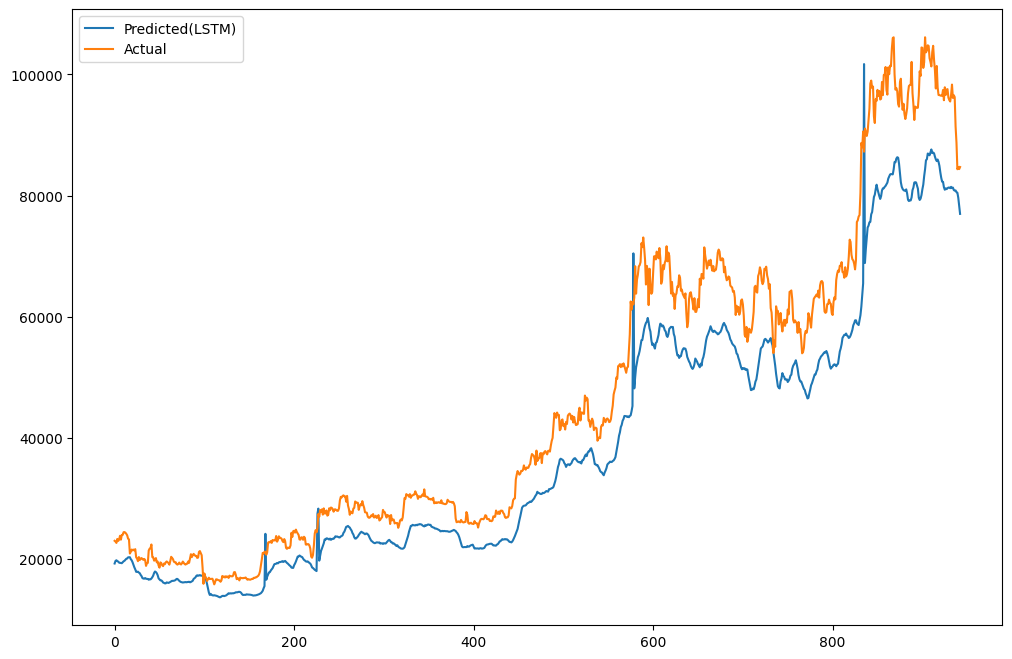

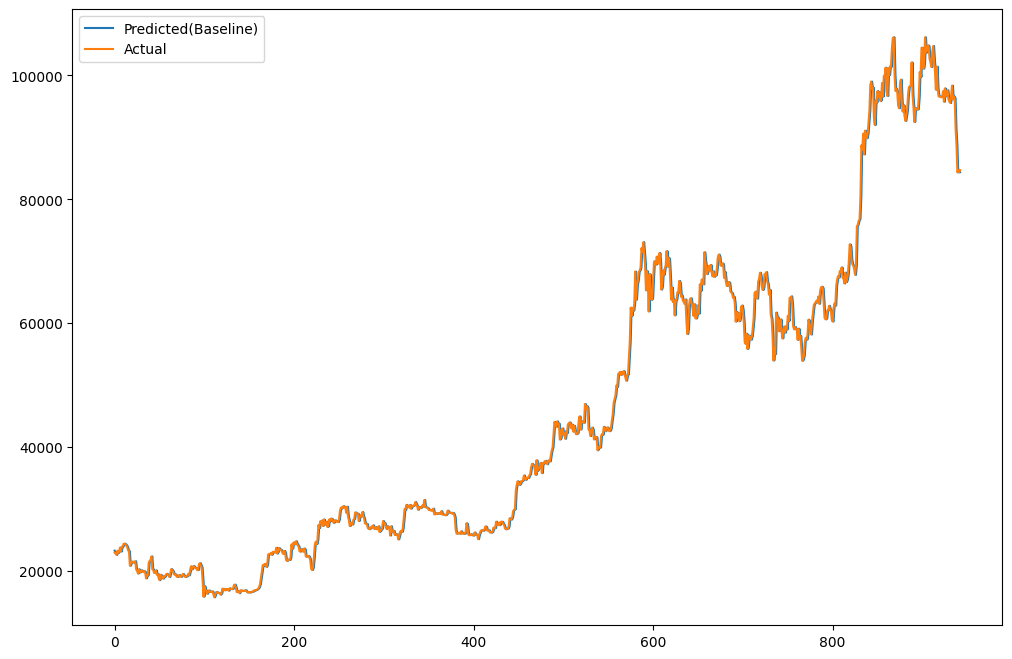

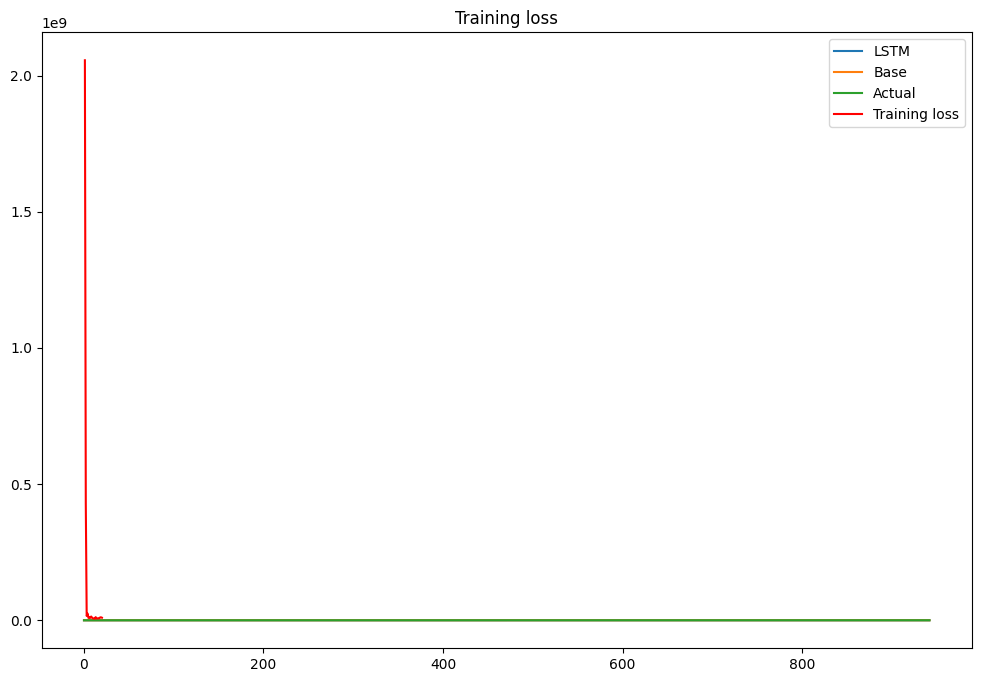

[[[21239.75390625]
  [22930.54882812]
  [23843.88671875]
  [23804.6328125 ]
  [23656.20703125]
  [23336.89648438]
  [23314.19921875]]] 

Predicted: 22679.607
Actual: 22978.1171875
Error: 298.509765625
Error%: 1.32
1 Predicted:22679.61  Actual:22978.12  Error:298.51->0.01
2 Predicted:23548.56  Actual:22846.51  Error:-702.05->0.03
3 Predicted:23844.07  Actual:22630.96  Error:-1213.11->0.05
4 Predicted:23712.69  Actual:23289.31  Error:-423.38->0.02
5 Predicted:23534.08  Actual:22961.28  Error:-572.8->0.02
6 Predicted:23342.22  Actual:23175.89  Error:-166.33->0.01
7 Predicted:23222.35  Actual:23809.49  Error:587.13->0.02
8 Predicted:23070.9  Actual:23164.32  Error:93.42->0.0
9 Predicted:23065.24  Actual:23947.64  Error:882.41->0.04
10 Predicted:23129.02  Actual:23957.53  Error:828.5->0.03
11 Predicted:23396.69  Actual:24402.82  Error:1006.12->0.04
12 Predicted:23413.08  Actual:24424.07  Error:1010.99->0.04
13 Predicted:23639.57  Actual:24319.33  Error:679.77->0.03
14 Predicted:23872.8  Act

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2128500864.0000
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1522358912.0000
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1134174336.0000
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 972865088.0000
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 703293760.0000
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 239095712.0000
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20858494.0000
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17985200.0000
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6993862.5000
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5244166.0000


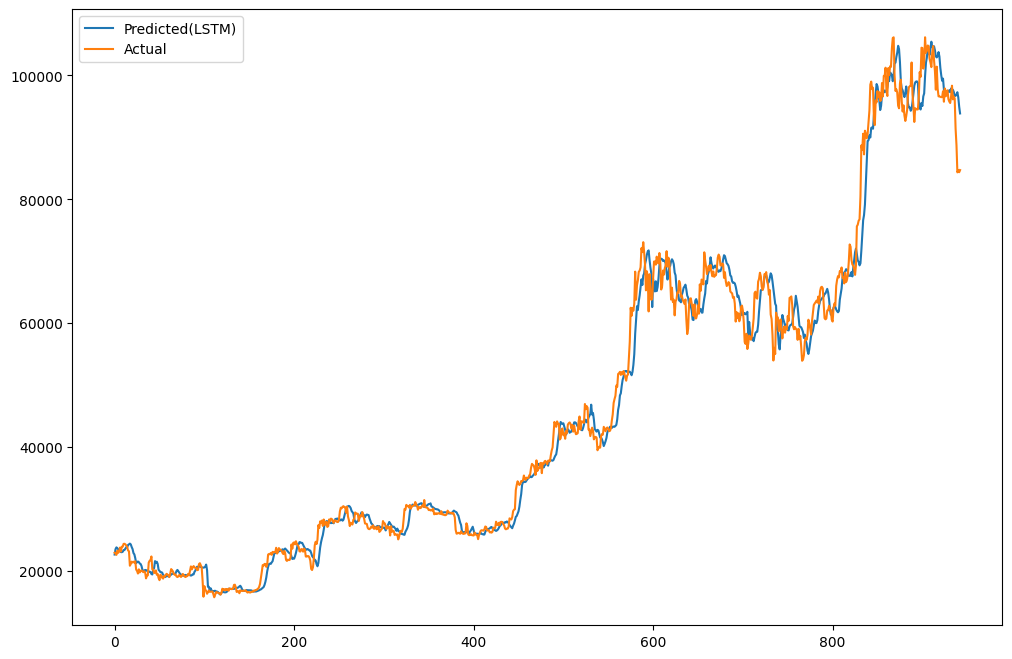

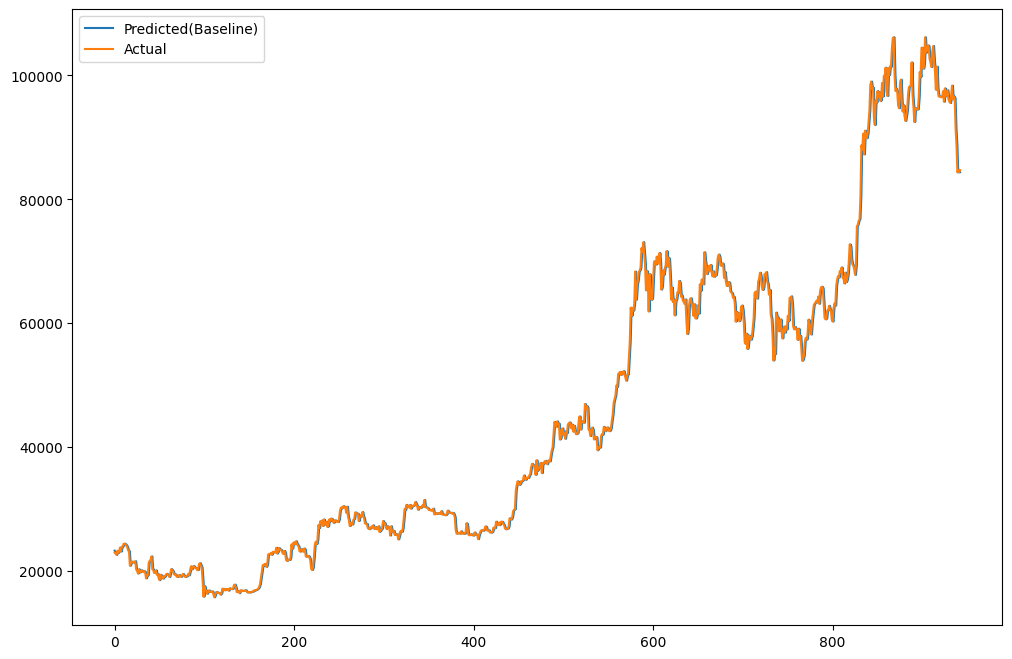

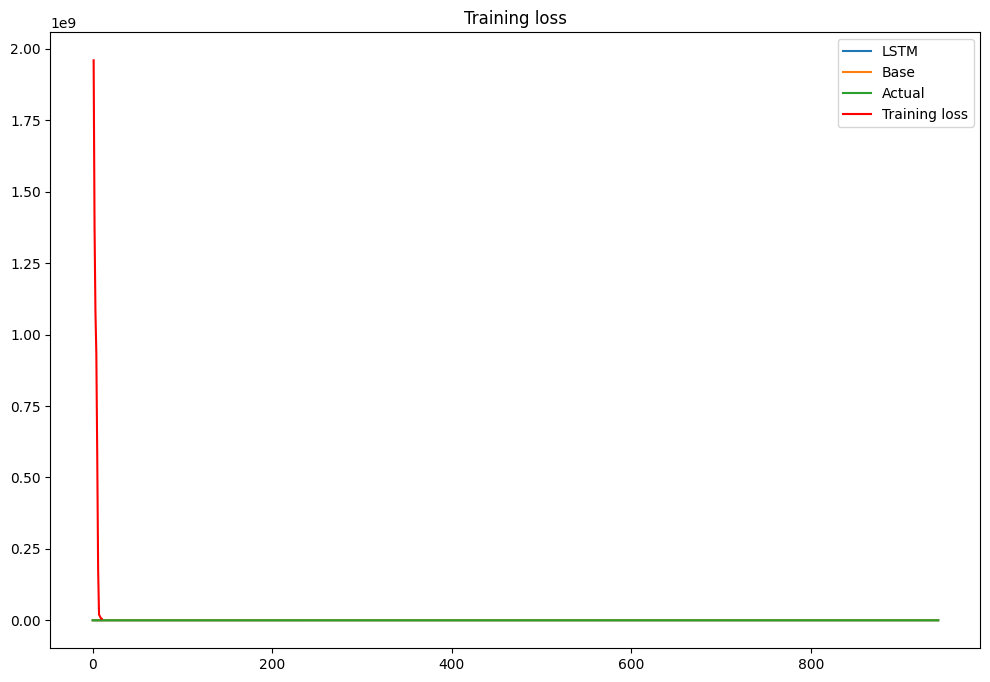

[[[49958.22265625]
  [49742.44140625]
  [51826.6953125 ]
  [51938.5546875 ]
  [52160.203125  ]
  [51662.99609375]
  [52122.546875  ]]] 

Predicted: 50643.008
Actual: 51779.14453125
Error: 1136.13671875
Error%: 2.2399999999999998
1 Predicted:50643.01  Actual:51779.14  Error:1136.14->0.02
2 Predicted:50975.86  Actual:52284.88  Error:1309.01->0.03
3 Predicted:51689.62  Actual:51839.18  Error:149.56->0.0
4 Predicted:51704.6  Actual:51304.97  Error:-399.62->0.01
5 Predicted:51501.68  Actual:50731.95  Error:-769.73->0.02
6 Predicted:51230.1  Actual:51571.1  Error:341.01->0.01
7 Predicted:51381.98  Actual:51733.24  Error:351.25->0.01
8 Predicted:51473.32  Actual:54522.4  Error:3049.08->0.06
9 Predicted:52265.72  Actual:57085.37  Error:4819.65->0.08
10 Predicted:53048.44  Actual:62504.79  Error:9456.35->0.15
11 Predicted:54664.01  Actual:61198.38  Error:6534.37->0.11
12 Predicted:55312.42  Actual:62440.63  Error:7128.21->0.11
13 Predicted:56239.7  Actual:62029.85  Error:5790.15->0.09
14 Predic

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 521395232.0000
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17818908.0000
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13149626.0000
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8256388.5000
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8972876.0000
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8020006.5000
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5933323.5000
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 144067120.0000
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 82321952.0000
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16366785.0000
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7447276.0000
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12716508.0000
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8527665.0000
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 84365

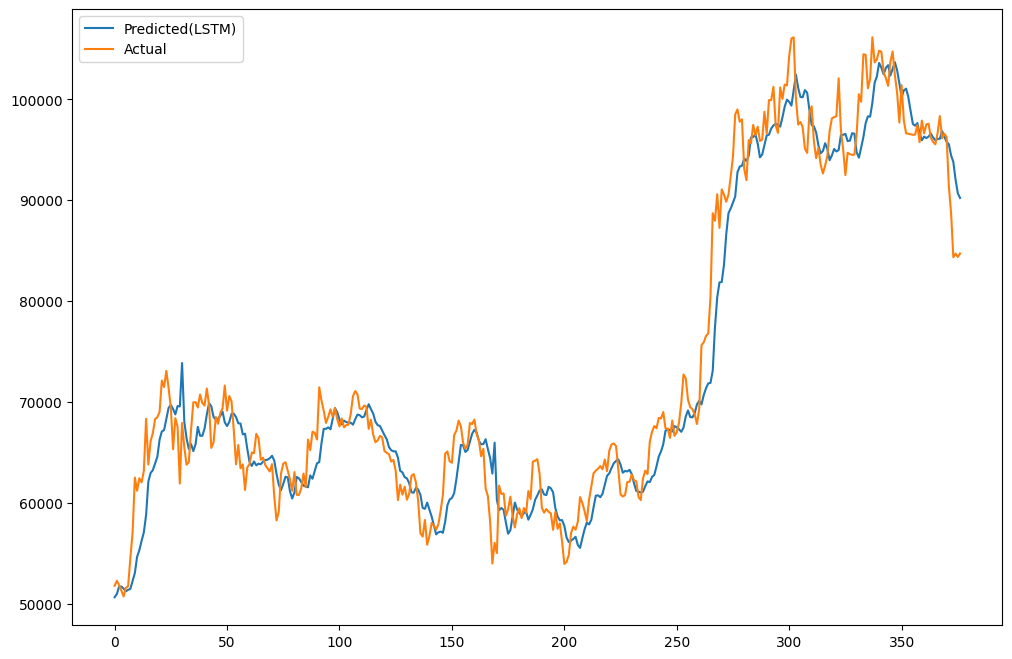

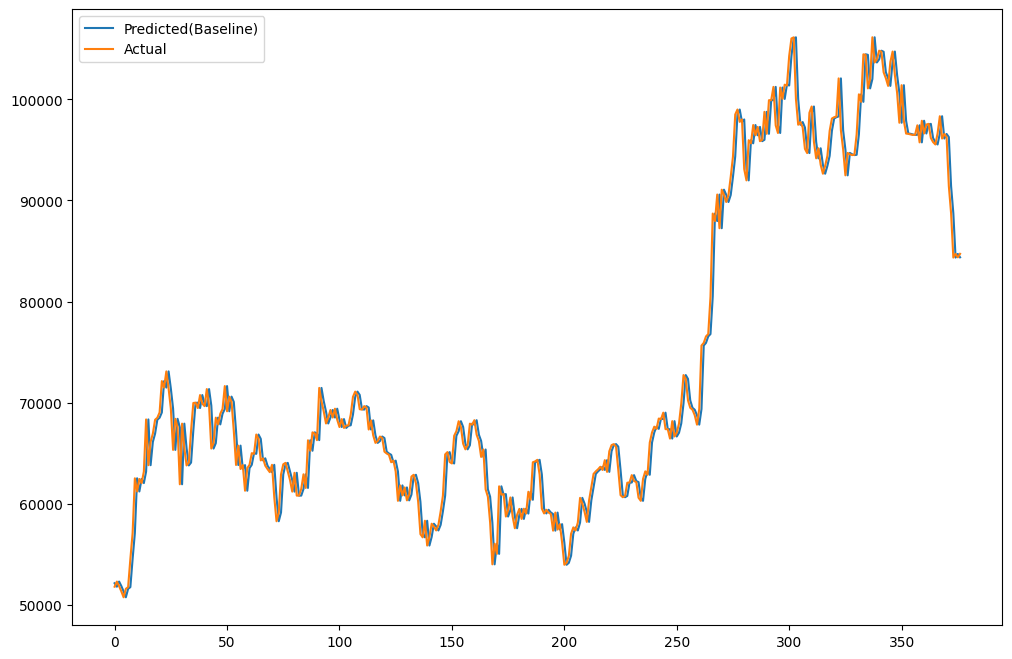

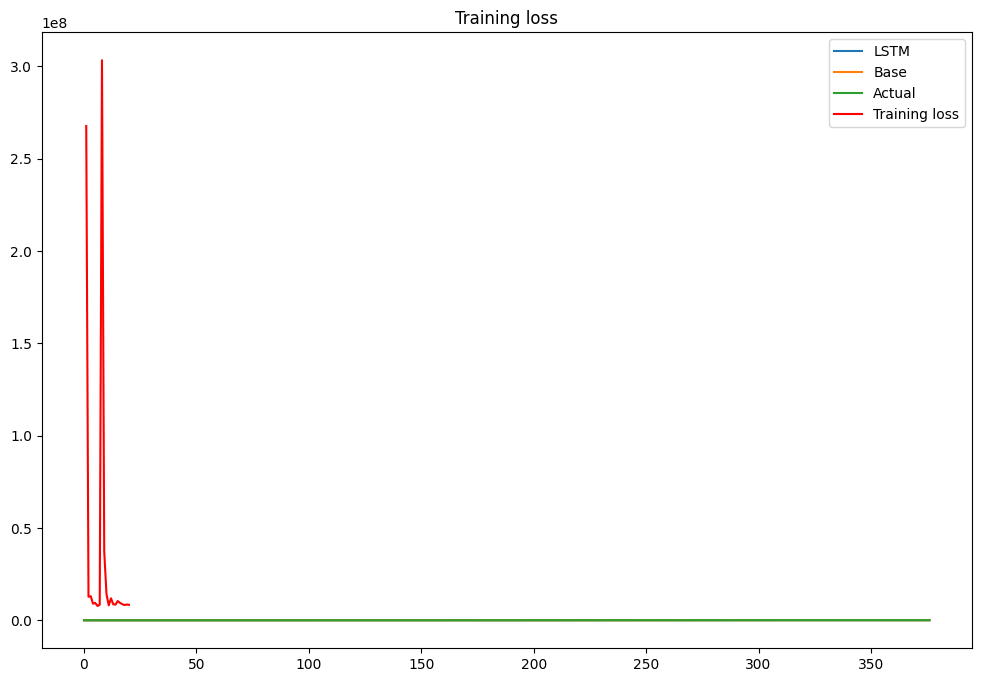

[[[49958.22265625]
  [49742.44140625]
  [51826.6953125 ]
  [51938.5546875 ]
  [52160.203125  ]
  [51662.99609375]
  [52122.546875  ]]] 

Predicted: 50138.594
Actual: 51779.14453125
Error: 1640.55078125
Error%: 3.27
1 Predicted:50138.6  Actual:51779.14  Error:1640.55->0.03
2 Predicted:50691.8  Actual:52284.88  Error:1593.08->0.03
3 Predicted:51370.06  Actual:51839.18  Error:469.12->0.01
4 Predicted:51537.12  Actual:51304.97  Error:-232.14->0.0
5 Predicted:51501.66  Actual:50731.95  Error:-769.71->0.02
6 Predicted:51454.56  Actual:51571.1  Error:116.54->0.0
7 Predicted:51438.72  Actual:51733.24  Error:294.51->0.01
8 Predicted:51306.98  Actual:54522.4  Error:3215.42->0.06
9 Predicted:51288.17  Actual:57085.37  Error:5797.2->0.1
10 Predicted:51194.7  Actual:62504.79  Error:11310.09->0.18
11 Predicted:50892.62  Actual:61198.38  Error:10305.76->0.17
12 Predicted:51562.58  Actual:62440.63  Error:10878.05->0.17
13 Predicted:52794.78  Actual:62029.85  Error:9235.07->0.15
14 Predicted:54529.34  

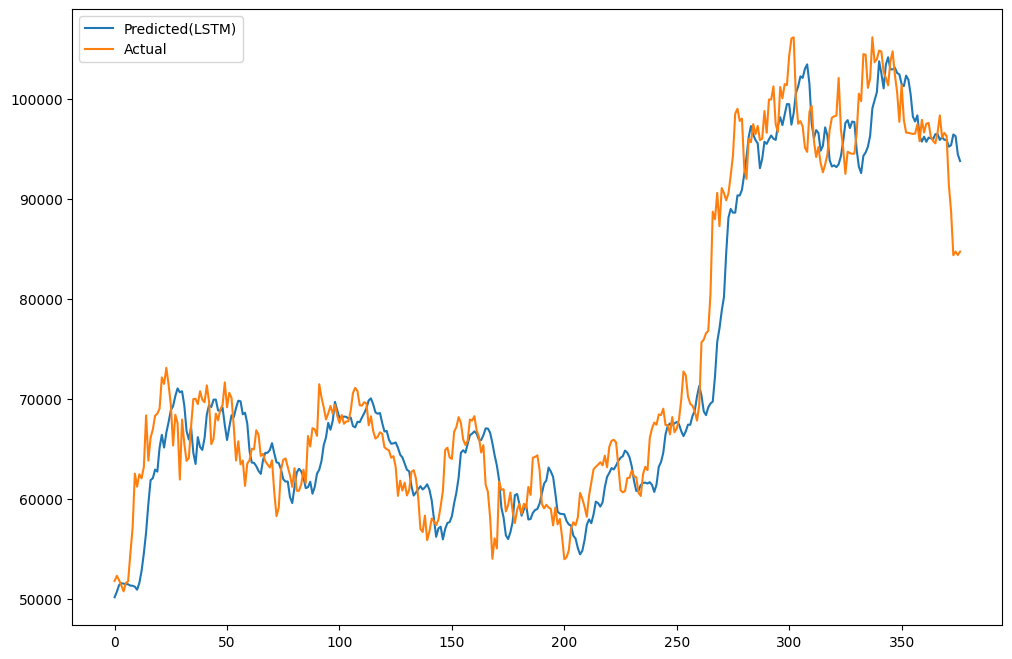

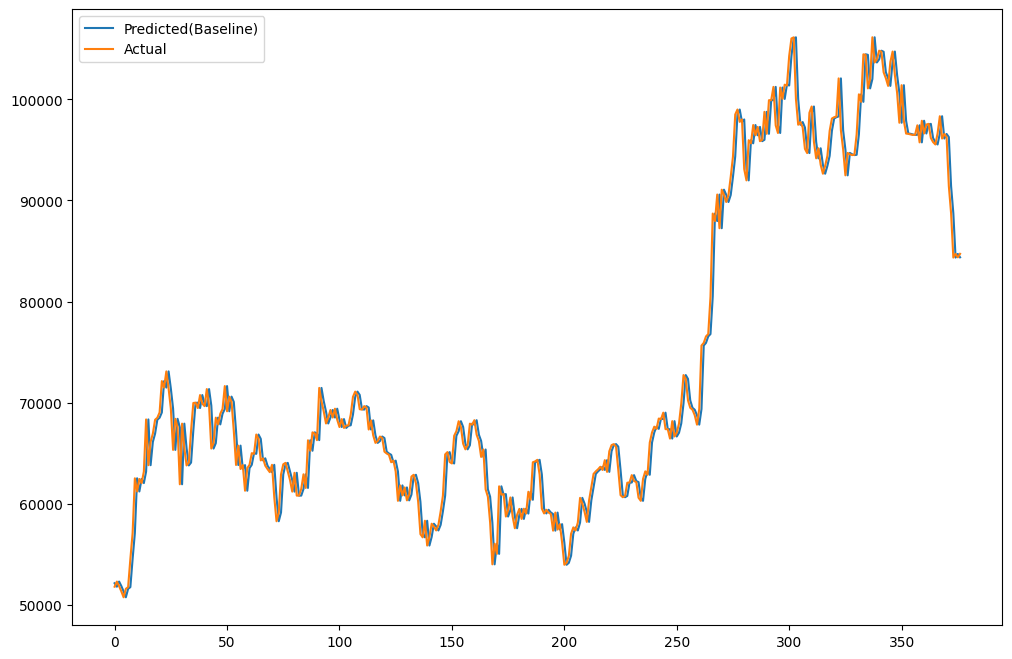

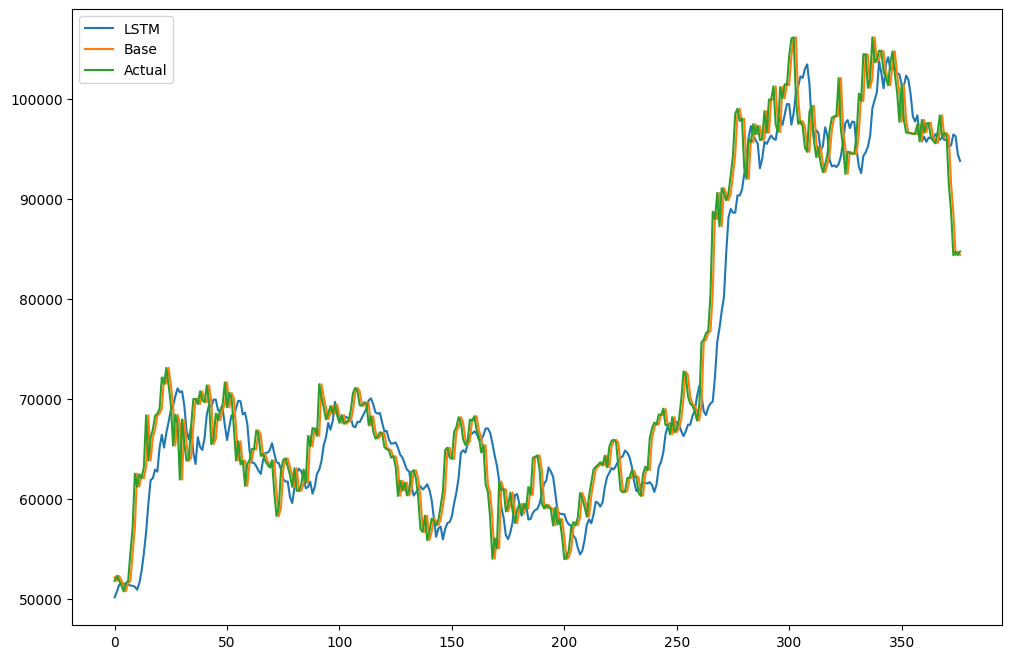

In [26]:
if not IS_INTERACTIVE:

   # train_ratio, n_steps, epochs, test_day

   train_ratio_list = [0.5, 0.8] # 0.5
   n_steps_list = [7] # 15
   epochs_list = [10, 20] # 10

   results_list = []

   test_day = 0

   for i in range(len(train_ratio_list)):
       for j in range(len(n_steps_list)):
           for k in range(len(epochs_list)):

               train_ratio = train_ratio_list[i]
               n_steps = n_steps_list[j]
               epochs = epochs_list[k]

               print("*******Start*******: Train Ratio: ", train_ratio, " n_steps: ", n_steps, " Epochs: ", epochs)

               raw_seq,train_seq,test_seq,data_size,train_size,test_size,n_features,df_close_train,df_close_test = divide_dataset(train_ratio)

               x_train, y_train = split_train_data(n_steps, n_features)

               model = construct_model(n_steps, n_features)

               model = LSTM_train_model(model, epochs)

               test_verify_prediction(model, n_steps, n_features, test_day)

               predictedList, actualList = plot_LSTM_prediction(model, data_size, train_size, n_steps, n_features)

               lstmError, lstmErrorP, rmse_lstm = print_predicted_and_actuals(predictedList, actualList)

               basePredictedList, baseActualList, baseline_rmse = compare_prediction_using_baseline(data_size, train_size, n_steps)

               plot_baseline_prediction(basePredictedList, baseActualList)

               plot_prediction_all(predictedList, basePredictedList, baseActualList)

               result = [train_ratio, n_steps, epochs, rmse_lstm, baseline_rmse]

               results_list.append(result)

               print("===============================***=====================================")
               print("Train Ratio: ", train_ratio, " N-Steps: ", n_steps, " Epochs: ", epochs, " LSTM RMSE: ", rmse_lstm, " Baseline RMSE: ", baseline_rmse )
               print("===============================***=====================================")


   for i in range(len(results_list)):
        print("Train Ratio: ", results_list[i][0], " N-Steps: ", results_list[i][1], " Epochs: ", results_list[i][2], " LSTM RMSE: ", results_list[i][3], " Baseline RMSE: ", results_list[i][4] )




In [27]:
def run_AR_model(data, actuals):

    #print(type(data['Close']))
    #print(data['Close'].tail(5))

    # Figure out optimum lags which will be 1 or 2 for this data set
    lags = ar_select_order(data['Close'], maxlag=30)



    print("Lags: " + str(lags.ar_lags))
    AR_model = AutoReg(data['Close'], lags.ar_lags)
    AR_model_fit = AR_model.fit()

    # Step: Perform forecast for the next 100 days (from 2024-02-17)
    forecast_steps = actuals.size
    #forecast_start = '2024-09-11'
    forecast_start = '2024-02-17'
    forecast_start = actuals.head(1).index.values[0]

    # Create future date range for forecast plot
    future_dates = pd.date_range(start=forecast_start, periods=forecast_steps, freq='B')  # 'B' means business days

    # Get forecast for the next 100 days

    forecast_AR = AR_model_fit.forecast(steps=forecast_steps)


    forecast_AR_series= forecast_AR.reset_index(drop=True)
    #print("forecast_AR: "+str(type(forecast_AR_series)))
    #print(forecast_AR_series)

    actuals_series = actuals['Close'].reset_index(drop=True)
    #print("actuals_series: " + str(type(actuals_series)))
    #print(actuals_series)
    # Get confidence intervals of the forecast
    #forecast_AR_ci = forecast_AR.conf_int()


    # Plot the original data and the forecast
    #plt.figure(figsize=(14, 7))
    plt.figure(figsize=(SCREEN_X, SCREEN_Y))
    plt.plot(data['Close'], label='Trained')
    plt.plot(actuals['Close'], label='Actual',color='green')
    plt.plot(future_dates, forecast_AR, label='Predicted', color='red')

    plt.title(short_name +' (' + ticker + ') Forecast for the Next ' + str(forecast_steps) + ' Days from ' + str(forecast_start) + ' using AutoRegressive(AR) Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    rmse_forecast_AR = statsmodels.tools.eval_measures.rmse(forecast_AR_series, actuals_series, axis=0)
    print("RMSE AR(" + str(lags.ar_lags) + "): " +str(rmse_forecast_AR))

    print(AR_model_fit.summary())



Lags: [1]


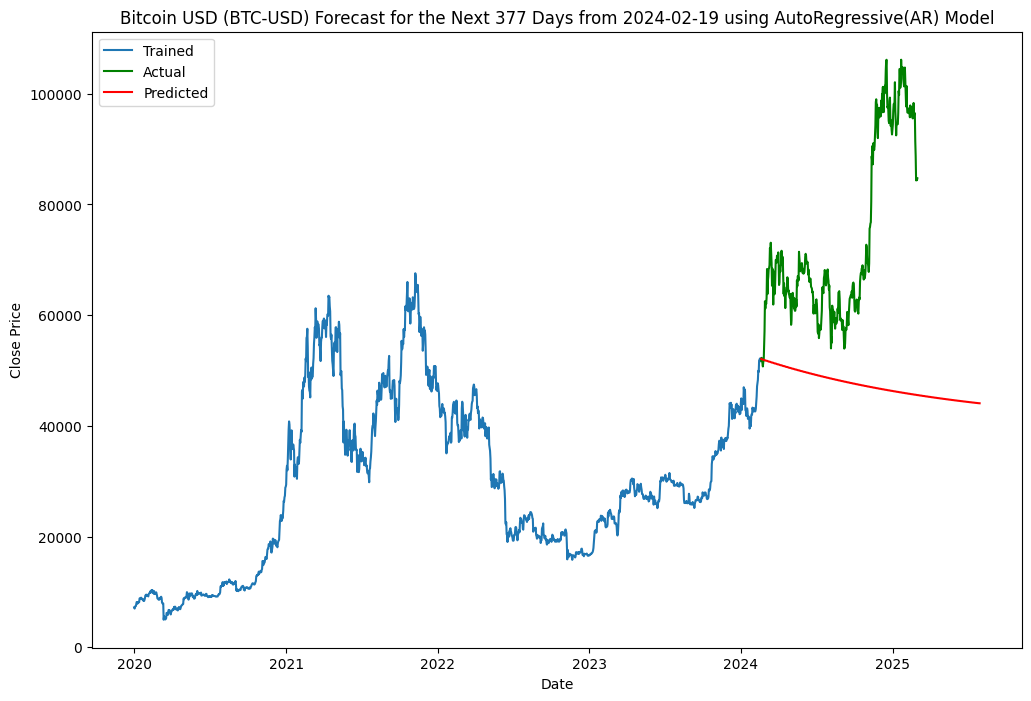

RMSE AR([1]): 31634.352337973734
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 1510
Model:                     AutoReg(1)   Log Likelihood              -12769.318
Method:               Conditional MLE   S.D. of innovations           1145.009
Date:                Sat, 01 Mar 2025   AIC                          25544.636
Time:                        11:16:51   BIC                          25560.593
Sample:                    01-02-2020   HQIC                         25550.579
                         - 02-18-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.0900     64.407      1.756      0.079     -13.146     239.326
Close.L1       0.9972      0.002    511.614      0.000       0.993       1.001
                   

In [28]:
if RUN_AR_MODEL:
    run_AR_model(df_close_train, df_close_test)

# Notes

*   Use more data features
*   Closing price is non-stationary and it more commonly to use **log-return**
